In [ ]:
from pyspark.sql import SparkSession

try:
    spark.stop()
    print("Old Spark session stopped.")
except Exception:
    print("No active Spark session — starting fresh.")

from pyspark.sql import SparkSession

from pyspark.sql import SparkSession

# Hard-coded safe settings for your SLURM job: 128 GB, 24 cores
SPARK_CORES = 12          
DRIVER_MEM  = "64g"      
SHUFFLE_PARTS = 320      

try:
    spark.stop()
except:
    pass

spark = (
    SparkSession.builder
        .appName("amex-spark")
        .master(f"local[{SPARK_CORES}]")
        .config("spark.driver.memory", DRIVER_MEM)
        .config("spark.sql.shuffle.partitions", str(SHUFFLE_PARTS))
        .config("spark.driver.maxResultSize", "4g")
        .config("spark.sql.adaptive.enabled", "true")
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
        .getOrCreate()
)

spark



Old Spark session stopped.


25/11/25 22:12:32 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Loading Data

In [ ]:
ROOT = "data/amex-raddar-parquet"
clean_path = ROOT + "/data_clean.parquet"

print("Reading cleaned parquet...")
df = spark.read.parquet(clean_path)

print("Data loaded. Schema:")
df.printSchema()

# --- ONE-TIME OPTIMAL REPARTITION & CACHE ---
print(f"Repartitioning to {SHUFFLE_PARTS} partitions and caching...")
df = df.repartition(SHUFFLE_PARTS)
df = df.cache()

print("Triggering cache ...")
row_count = df.count()     # ← ONLY ONE COUNT (forces full materialization)

print("\n" + "="*80)
print("DATA FULLY LOADED & CACHED — LIGHTNING READY!")
print(f"Rows                : {row_count:,}")
print(f"Columns             : {len(df.columns)}")
print(f"Partitions          : {df.rdd.getNumPartitions()}")
print(f"Rows per partition  : ~{row_count // df.rdd.getNumPartitions():,}")
print("="*80)


Reading cleaned parquet...


Data loaded. Schema:
root
 |-- customer_ID: string (nullable = true)
 |-- date: timestamp_ntz (nullable = true)
 |-- P_2: float (nullable = true)
 |-- D_39: float (nullable = true)
 |-- B_1: float (nullable = true)
 |-- B_2: float (nullable = true)
 |-- R_1: float (nullable = true)
 |-- S_3: float (nullable = true)
 |-- D_41: float (nullable = true)
 |-- B_3: float (nullable = true)
 |-- D_42: float (nullable = true)
 |-- D_43: float (nullable = true)
 |-- D_44: float (nullable = true)
 |-- B_4: float (nullable = true)
 |-- D_45: float (nullable = true)
 |-- B_5: float (nullable = true)
 |-- R_2: float (nullable = true)
 |-- D_46: float (nullable = true)
 |-- D_47: float (nullable = true)
 |-- D_48: float (nullable = true)
 |-- D_49: float (nullable = true)
 |-- B_6: float (nullable = true)
 |-- B_7: float (nullable = true)
 |-- B_8: float (nullable = true)
 |-- D_50: float (nullable = true)
 |-- D_51: float (nullable = true)
 |-- B_9: float (nullable = true)
 |-- R_3: float (nullable 

25/11/25 22:13:01 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Triggering cache ...



DATA FULLY LOADED & CACHED — LIGHTNING READY!
Rows                : 16,895,213
Columns             : 192
Partitions          : 320
Rows per partition  : ~52,797


# Null / NaN Profiling

In [4]:
from pyspark.sql import functions as F   

# --- Define categorical columns ---
categorical_cols = [
    'B_30','B_38','D_114','D_116','D_117','D_120','D_126','D_63','D_64','D_66','D_68'
]

# --- Identify numeric columns automatically ---
all_cols = df.columns
id_cols = ['customer_ID', 'date', 'test']   # exclude these from feature/nan checks
label_col = 'target'

numeric_cols = [
    c for c in all_cols
    if c not in categorical_cols + id_cols + [label_col]
]

print("Numeric columns:", len(numeric_cols))
print("Categorical columns:", len(categorical_cols))


# ---------------------------
# 1. Null + NaN count per column
# ---------------------------

# Build Spark expressions for each column
exprs = []
for c in df.columns:
    if c in categorical_cols or c in id_cols:
        # Categorical / ID → only NULL counts
        exprs.append(F.sum(F.col(c).isNull().cast("int")).alias(c))
    elif c == label_col:
        # Label may have nulls too
        exprs.append(F.sum(F.col(c).isNull().cast("int")).alias(c))
    else:
        # Numeric → NULL + NaN
        exprs.append(
            F.sum(
                F.col(c).isNull().cast("int")
                + F.isnan(F.col(c).cast("double")).cast("int")
            ).alias(c)
        )

null_counts = df.select(exprs)
null_counts.show(truncate=False)


# ---------------------------
# 2. Null percentage per column
# ---------------------------

row_count = df.count()

null_pct = null_counts.select([
    (F.col(c) / row_count * 100).alias(c) for c in null_counts.columns
])

print("Null/NaN percentages per column:")
null_pct.show(truncate=False)


Numeric columns: 177
Categorical columns: 11


+-----------+----+------+----+---+----+---+-------+----+----+--------+-------+------+---+----+---+---+-------+----+-------+--------+----+---+------+-------+----+---+---+-----+------+----+--------+---+----+---+----+---+-------+----+---+------+-------+------+---+----+-------+----+------+----+-------+-----+----+-------+----+------+----+----+-------+----+----+--------+----+------+----+---+----+----+------+----+------+----+-----+----+----+--------+---+-----+----+--------+----+---+-------+-----+----+------+------+---+--------+----+-----+----+----+----+-----+--------+-----+----+----+----+------+----+----+-----+----+--------+----+----+----+--------+----+----+--------+----+----+----+----+----+----+----+----+-----+----+----+------+----+----+----+----+----+----+-----+----+-----+-----+----+-----+------+------+-------+--------+------+----+----+--------+------+----+--------+-----+--------+--------+--------+-----+----+-------+------+------+------+------+------+------+------+------+------+------+-----

+-----------+----+------------------+----+---+------------------+---+------------------+------------------+------------------+-----------------+-----------------+-----------------+---+--------------------+---+---+------------------+----+------------------+-----------------+--------------------+---+------------------+-----------------+----+---+---+------------------+-----------------+----+-----------------+---+----+---+------------------+---+------------------+----+---+---------------+------------------+------------------+---+----+-----------------+----+------------------+----+------------------+-------------------+----+----------------+----+------------------+----+------------------+------------------+----+------------------+-----------------+------------------+------------------+--------------------+---+----+----+------------------+------------------+-----------------+----+------------------+----+----+-----------------+---+-------------------+----+-----------------+----+--------------

In [5]:
from functools import reduce

feature_cols = [
    c for c in df.columns
    if c not in id_cols + [label_col]
]

# Separate numeric vs categorical (reuse from Cell 3 if already defined)
numeric_cols = [
    c for c in feature_cols
    if c not in categorical_cols
]

print("Total feature columns:", len(feature_cols))
print("Numeric feature columns:", len(numeric_cols))
print("Categorical feature columns:", len(categorical_cols))


Total feature columns: 188
Numeric feature columns: 177
Categorical feature columns: 11


# Data Cleaning

In [7]:
from functools import reduce
from pyspark.sql import functions as F
import time

print("Starting data cleaning...")

# --- Define column groups ---
id_cols      = ['customer_ID', 'date', 'test']
label_col    = 'target'
categorical_cols = ['B_30','B_38','D_114','D_116','D_117',
                    'D_120','D_126','D_63','D_64','D_66','D_68']

# Filter to existing categorical columns
categorical_cols = [c for c in categorical_cols if c in df.columns]

# Auto-detect numeric columns
numeric_cols = [
    c for c, t in df.dtypes
    if c not in id_cols + [label_col] + categorical_cols
    and t in ('int', 'bigint', 'float', 'double', 'smallint', 'tinyint')
]

feature_cols = numeric_cols + categorical_cols
print(f"Total feature columns: {len(feature_cols)} (numeric: {len(numeric_cols)}, cat: {len(categorical_cols)})")

# --------------------------------------------------------------
# 1) Drop rows where ALL feature columns are null/NaN
# --------------------------------------------------------------

print("Building condition to drop rows with ALL features missing...")

conditions = (
    [F.col(c).isNull() | F.isnan(c) for c in numeric_cols] +
    [F.col(c).isNull() for c in categorical_cols]
)

if conditions:
    all_null_cond = reduce(lambda x, y: x & y, conditions)
    df_no_allnull = df.filter(~all_null_cond)
else:
    df_no_allnull = df  # no features → keep all

rows_before = df.count()
rows_after  = df_no_allnull.count()
print(f"Rows before: {rows_before:,}")
print(f"Rows after dropping all-null-feature rows: {rows_after:,}")

# --------------------------------------------------------------
# 2) Drop columns with >95% missing
# --------------------------------------------------------------

missing_threshold = 0.95
row_count = rows_after

print(f"Computing missing rates for {len(feature_cols)} feature columns...")

null_exprs = []
for c in feature_cols:
    if c in numeric_cols:
        null_exprs.append(
            F.sum((F.col(c).isNull() | F.isnan(c)).cast("int")).alias(c)
        )
    else:
        null_exprs.append(F.sum(F.col(c).isNull().cast("int")).alias(c))

missing_counts = df_no_allnull.select(null_exprs).first().asDict()
drop_cols = [
    c for c in feature_cols
    if missing_counts.get(c, 0) / row_count > missing_threshold
]

print(f"Columns to drop (> {missing_threshold*100:.0f}% missing): {len(drop_cols)}")
print(drop_cols)

df_clean = df_no_allnull.drop(*drop_cols)

print(f"Final number of columns: {len(df_clean.columns)}")
df_clean.printSchema()

# --------------------------------------------------------------
# 3) REPARTITION + CACHE df_clean
# --------------------------------------------------------------

print("Optimizing df_clean for maximum performance...")
df_clean = df_clean.repartition(SHUFFLE_PARTS)   
df_clean = df_clean.cache()

print("Triggering cache on df_clean ...")
start_cache = time.time()
cached_rows = df_clean.count()
print(f"Cache ready in {time.time() - start_cache:.1f}s")

print("\n" + "="*80)
print(f"Rows       : {cached_rows:,}")
print(f"Columns    : {len(df_clean.columns)}")
print(f"Partitions : {df_clean.rdd.getNumPartitions()}")
print("="*80)


Starting data cleaning...
Total feature columns: 188 (numeric: 177, cat: 11)
Building condition to drop rows with ALL features missing...


25/11/25 22:16:25 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.


Rows before: 16,895,213
Rows after dropping all-null-feature rows: 16,895,213
Computing missing rates for 188 feature columns...


25/11/25 22:16:32 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.


Columns to drop (> 95% missing): 13
['D_73', 'D_87', 'D_88', 'D_108', 'D_110', 'D_111', 'B_39', 'B_42', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138']
Final number of columns: 179
root
 |-- customer_ID: string (nullable = true)
 |-- date: timestamp_ntz (nullable = true)
 |-- P_2: float (nullable = true)
 |-- D_39: float (nullable = true)
 |-- B_1: float (nullable = true)
 |-- B_2: float (nullable = true)
 |-- R_1: float (nullable = true)
 |-- S_3: float (nullable = true)
 |-- D_41: float (nullable = true)
 |-- B_3: float (nullable = true)
 |-- D_42: float (nullable = true)
 |-- D_43: float (nullable = true)
 |-- D_44: float (nullable = true)
 |-- B_4: float (nullable = true)
 |-- D_45: float (nullable = true)
 |-- B_5: float (nullable = true)
 |-- R_2: float (nullable = true)
 |-- D_46: float (nullable = true)
 |-- D_47: float (nullable = true)
 |-- D_48: float (nullable = true)
 |-- D_49: float (nullable = true)
 |-- B_6: float (nullable = true)
 |-- B_7: float (nullable = true)
 |-- B_

25/11/25 22:16:45 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.


Triggering cache on df_clean (30–60 sec first time)...


Cache ready in 28.5s

Rows       : 16,895,213
Columns    : 179
Partitions : 320


In [ ]:
# from functools import reduce
# from pyspark.sql import functions as F
# import time

# # --------------------------------------------------------------
# # CLEANING PIPELINE — TOP-1 AMEX STYLE (FAST + CORRECT)
# # --------------------------------------------------------------

# print("Starting data cleaning...")

# # --- Define column groups (must be defined BEFORE using them!) ---
# id_cols      = ['customer_ID', 'date', 'test']
# label_col    = 'target'
# categorical_cols = ['B_30','B_38','D_114','D_116','D_117',
#                     'D_120','D_126','D_63','D_64','D_66','D_68']

# # Filter to existing categorical columns
# categorical_cols = [c for c in categorical_cols if c in df.columns]

# # Auto-detect numeric columns
# numeric_cols = [
#     c for c, t in df.dtypes
#     if c not in id_cols + [label_col] + categorical_cols
#     and t in ('int', 'bigint', 'float', 'double', 'smallint', 'tinyint')
# ]

# feature_cols = numeric_cols + categorical_cols
# print(f"Total feature columns: {len(feature_cols)} (numeric: {len(numeric_cols)}, cat: {len(categorical_cols)})")

# # --------------------------------------------------------------
# # 1) Drop rows where ALL feature columns are null/NaN
# # --------------------------------------------------------------

# print("Building condition to drop rows with ALL features missing...")

# # For numeric: null OR NaN
# # For categorical: only null
# conditions = (
#     [F.col(c).isNull() | F.isnan(c) for c in numeric_cols] +
#     [F.col(c).isNull() for c in categorical_cols]
# )

# # Combine with AND
# if conditions:
#     all_null_cond = reduce(lambda x, y: x & y, conditions)
#     df_no_allnull = df.filter(~all_null_cond)
# else:
#     df_no_allnull = df  # no features → keep all

# print(f"Rows before: {df.count():,}")
# print(f"Rows after dropping all-null-feature rows: {df_no_allnull.count():,}")

# # --------------------------------------------------------------
# # 2) Drop columns with >95% missing
# # --------------------------------------------------------------

# missing_threshold = 0.95
# row_count = df_no_allnull.count()

# print(f"Computing missing rates for {len(feature_cols)} feature columns...")

# null_exprs = []
# for c in feature_cols:
#     if c in numeric_cols:
#         null_exprs.append(
#             F.sum((F.col(c).isNull() | F.isnan(c)).cast("int")).alias(c)
#         )
#     else:
#         null_exprs.append(F.sum(F.col(c).isNull().cast("int")).alias(c))

# missing_counts = df_no_allnull.select(null_exprs).first().asDict()
# drop_cols = [
#     c for c in feature_cols
#     if missing_counts.get(c, 0) / row_count > missing_threshold
# ]

# print(f"Columns to drop (> {missing_threshold*100:.0f}% missing): {len(drop_cols)}")
# print(drop_cols)

# # Drop them
# df_clean = df_no_allnull.drop(*drop_cols)

# print(f"Final number of columns: {len(df_clean.columns)}")
# df_clean.printSchema()

# # --------------------------------------------------------------
# # REPARTITION + CACHE df_clean
# # --------------------------------------------------------------

# print("Optimizing df_clean for maximum performance...")
# df_clean = df_clean.repartition(hw["recommended_parts"])   # <<<<<< fixed key
# df_clean = df_clean.cache()

# print("Triggering cache on df_clean (30–60 sec first time)...")
# start_cache = time.time()
# cached_rows = df_clean.count()
# print(f"Cache ready in {time.time() - start_cache:.1f}s")

# print("\n" + "="*80)
# print(f"Rows       : {cached_rows:,}")
# print(f"Columns    : {len(df_clean.columns)}")
# print(f"Partitions : {df_clean.rdd.getNumPartitions()}")
# print("="*80)


Starting data cleaning...
Total feature columns: 188 (numeric: 177, cat: 11)
Building condition to drop rows with ALL features missing...
Rows before: 16,895,213


25/11/25 22:07:09 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.


Rows after dropping all-null-feature rows: 16,895,213


25/11/25 22:07:14 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.


Computing missing rates for 188 feature columns...


25/11/25 22:07:20 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/11/25 22:07:31 WARN CacheManager: Asked to cache already cached data.        


Columns to drop (> 95% missing): 13
['D_73', 'D_87', 'D_88', 'D_108', 'D_110', 'D_111', 'B_39', 'B_42', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138']
Final number of columns: 179
root
 |-- customer_ID: string (nullable = true)
 |-- date: timestamp_ntz (nullable = true)
 |-- P_2: float (nullable = true)
 |-- D_39: float (nullable = true)
 |-- B_1: float (nullable = true)
 |-- B_2: float (nullable = true)
 |-- R_1: float (nullable = true)
 |-- S_3: float (nullable = true)
 |-- D_41: float (nullable = true)
 |-- B_3: float (nullable = true)
 |-- D_42: float (nullable = true)
 |-- D_43: float (nullable = true)
 |-- D_44: float (nullable = true)
 |-- B_4: float (nullable = true)
 |-- D_45: float (nullable = true)
 |-- B_5: float (nullable = true)
 |-- R_2: float (nullable = true)
 |-- D_46: float (nullable = true)
 |-- D_47: float (nullable = true)
 |-- D_48: float (nullable = true)
 |-- D_49: float (nullable = true)
 |-- B_6: float (nullable = true)
 |-- B_7: float (nullable = true)
 |-- B_

# Imputation (vectorized, PySpark ML)

In [8]:
from pyspark.sql import functions as F
import time

start = time.time()

# REBUILD numeric_cols FROM THE CURRENT df_clean (CRITICAL!)
numeric_cols = [
    c for c, t in df_clean.dtypes
    if c not in id_cols + [label_col] + categorical_cols
    and t in ('int', 'bigint', 'float', 'double', 'smallint', 'tinyint')
]

print(f"Using {len(numeric_cols)} numeric columns that actually exist")

# ONE JOB — compute means
print("Computing means ...")
mean_exprs = [F.mean(c).alias(f"{c}_mean") for c in numeric_cols]
means_row = df_clean.select(*mean_exprs).first()

mean_dict = {c: means_row[f"{c}_mean"] for c in numeric_cols}
broadcast_means = spark.sparkContext.broadcast(mean_dict)

print(f"Means computed in {time.time()-start:.1f}s")

# Imputation
print("Applying mean imputation...")
df_imputed = (
    df_clean.select(
        *[F.coalesce(F.col(c), F.lit(broadcast_means.value[c])).alias(c)
          if c in numeric_cols else F.col(c)
          for c in df_clean.columns]
    )
    .fillna("missing", subset=categorical_cols)
    .cache()
)

df_imputed.count()
print(f"\nIMPUTATION DONE IN {time.time()-start:.1f} SECONDS — PERFECT!")


Using 164 numeric columns that actually exist
Computing means ...


Means computed in 14.4s
Applying mean imputation...



IMPUTATION DONE IN 47.9 SECONDS — PERFECT!


# StringIndex for Categorical Columns

In [9]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline


# New names for indexed columns
categorical_indexed_cols = [c + "_idx" for c in categorical_cols]
# One StringIndexer per categorical column

indexers = [
    StringIndexer(
        inputCol=c,
        outputCol=c + "_idx",
        handleInvalid="keep"   # important: keep unseen/Null as a valid index
    )
    for c in categorical_cols
]

# Build and fit pipeline
indexer_pipeline = Pipeline(stages=indexers)
df_indexed = indexer_pipeline.fit(df_imputed).transform(df_imputed)

print("Indexed categorical columns added:")
print(categorical_indexed_cols)
df_indexed.select(categorical_cols + categorical_indexed_cols).show(5, truncate=False)


Indexed categorical columns added:
['B_30_idx', 'B_38_idx', 'D_114_idx', 'D_116_idx', 'D_117_idx', 'D_120_idx', 'D_126_idx', 'D_63_idx', 'D_64_idx', 'D_66_idx', 'D_68_idx']
+----+----+-----+-----+-----+-----+-----+----+----+----+----+--------+--------+---------+---------+---------+---------+---------+--------+--------+--------+--------+
|B_30|B_38|D_114|D_116|D_117|D_120|D_126|D_63|D_64|D_66|D_68|B_30_idx|B_38_idx|D_114_idx|D_116_idx|D_117_idx|D_120_idx|D_126_idx|D_63_idx|D_64_idx|D_66_idx|D_68_idx|
+----+----+-----+-----+-----+-----+-----+----+----+----+----+--------+--------+---------+---------+---------+---------+---------+--------+--------+--------+--------+
|0.0 |1.0 |0.0  |0.0  |-1.0 |0.0  |1.0  |CO  |O   |NULL|6.0 |0.0     |2.0     |1.0      |0.0      |0.0      |0.0      |0.0      |0.0     |0.0     |2.0     |0.0     |
|1.0 |5.0 |1.0  |0.0  |4.0  |0.0  |1.0  |CO  |O   |NULL|5.0 |1.0     |3.0     |0.0      |0.0      |1.0      |0.0      |0.0      |0.0     |0.0     |2.0     |1.0    

# VectorAssembler + StandardScaler

In [10]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# 1) Identify numeric feature columns (already imputed in df_imputed/df_indexed)
numeric_types = ('int', 'bigint', 'float', 'double', 'smallint', 'tinyint')

numeric_feature_cols = [
    c for c, t in df_indexed.dtypes
    if c not in id_cols + [label_col] + categorical_cols + categorical_indexed_cols
    and t in numeric_types
]

print("Numeric feature columns:", len(numeric_feature_cols))
print("Categorical indexed feature columns:", len(categorical_indexed_cols))

# 2) All input feature columns for the model
feature_input_cols = numeric_feature_cols + categorical_indexed_cols
print("Total feature columns going into assembler:", len(feature_input_cols))

# 3) VectorAssembler → features_unnorm
assembler = VectorAssembler(
    inputCols=feature_input_cols,
    outputCol="features_unnorm"
)

df_assembled = assembler.transform(df_indexed)

# 4) StandardScaler → features (final feature vector)
scaler = StandardScaler(
    inputCol="features_unnorm",
    outputCol="features",
    withStd=True,   # scale to unit variance
    withMean=True   # center to mean 0 (ok for tree models too, just consistent)
)


scaler_model = scaler.fit(df_assembled)
df_final = scaler_model.transform(df_assembled)

# Keep main columns: IDs, label, and features
df_final = df_final.select("customer_ID", "date", label_col, "test", "features")

print("Final dataframe for modeling:")
df_final.printSchema()
df_final.show(5, truncate=False)


Numeric feature columns: 164
Categorical indexed feature columns: 11
Total feature columns going into assembler: 175


Final dataframe for modeling:
root
 |-- customer_ID: string (nullable = true)
 |-- date: timestamp_ntz (nullable = true)
 |-- target: byte (nullable = true)
 |-- test: byte (nullable = true)
 |-- features: vector (nullable = true)

+----------------------------------------------------------------+-------------------+------+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Set Label Column + Train/Test Split

In [11]:
from pyspark.sql import functions as F

# 1) Ensure label is numeric (Spark GBT needs double)
df_final = df_final.withColumn(label_col, F.col(label_col).cast("double"))

# Optional: drop rows with null labels (rare, but safe)
df_final = df_final.filter(F.col(label_col).isNotNull())

# 2) Train–test split (80/20 is standard)
train_df, test_df = df_final.randomSplit([0.8, 0.2], seed=42)

# 3) Cache for faster training
train_df = train_df.cache()
test_df = test_df.cache()

print("Train rows:", train_df.count())
print("Test rows:", test_df.count())

train_df.show(5, truncate=False)


Train rows: 4424717


Test rows: 1106734
+----------------------------------------------------------------+-------------------+------+----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Checking for Class Imbalance

In [12]:
from pyspark.sql import functions as F

label_col = "target"

print("Class distribution:")
class_dist = (
    df_final.groupBy(label_col)
            .count()
            .withColumn("percentage", F.col("count") / df_final.count() * 100)
            .orderBy(label_col)
)

class_dist.show(truncate=False)


Class distribution:
+------+-------+------------------+
|target|count  |percentage        |
+------+-------+------------------+
|0.0   |4153582|75.0902792052212  |
|1.0   |1377869|24.909720794778803|
+------+-------+------------------+



# Train a Gradient-Boosted Trees Classifier (GBTClassifier)

In [13]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F

# NOTE:
# GBTClassifier in Spark expects:
#   - features column named "features"
#   - label column of type DOUBLE
# Both were created in Cell 9.

# NOTE:
# The dataset is imbalanced (~75% class 0, ~25% class 1).
# We compute inverse-frequency weights dynamically, so the model
# learns to pay more attention to the minority class (label 1).


label_col = "target"
features_col = "features"

# Compute class weights: inverse frequency
class_counts = (
    train_df.groupBy(label_col).count()
             .withColumnRenamed("count", "n")
)

total = class_counts.agg(F.sum("n")).first()[0]

# Dictionary: label -> weight
weights = {
    row[label_col]: float(total) / float(row["n"])
    for row in class_counts.collect()
}

print("Class weights:", weights)

# Add weightCol to training dataframe
train_df_weighted = train_df.withColumn(
    "class_weight",
    F.when(F.col(label_col) == 1, F.lit(weights.get(1.0)))
     .otherwise(F.lit(weights.get(0.0)))
)


# -------------------------------------------------------------------
# Define the GBT model
# -------------------------------------------------------------------
# Key notes:
#  - maxDepth controls tree complexity
#  - maxIter controls number of boosting rounds
#  - stepSize is learning rate (smaller = more stable)
#  - weightCol handles class imbalance
# -------------------------------------------------------------------

gbt = GBTClassifier(
    labelCol=label_col,
    featuresCol=features_col,
    weightCol="class_weight",   # using weighted training
    maxDepth=6,                 # reasonable starting depth
    maxIter=60,                 # number of boosting rounds
    stepSize=0.1,               # learning rate
    subsamplingRate=0.8,        # stochastic boosting for stability
    maxBins=32                  # number of bins for continuous features
)

print("Training GBT model...")

model = gbt.fit(train_df_weighted)

print("Model training complete.")

Class weights: {1.0: 4.013155830150569, 0.0: 1.3318779566571668}
Training GBT model...


25/11/25 22:26:14 WARN BlockManager: Asked to remove block rdd_1339_50, which does not exist
25/11/25 22:26:14 WARN BlockManager: Asked to remove block rdd_1339_21, which does not exist
25/11/25 22:26:14 WARN BlockManager: Asked to remove block rdd_1339_139, which does not exist
25/11/25 22:26:14 WARN BlockManager: Asked to remove block rdd_1339_105, which does not exist
25/11/25 22:26:14 WARN BlockManager: Asked to remove block rdd_1339_34, which does not exist
25/11/25 22:26:14 WARN BlockManager: Asked to remove block rdd_1339_197, which does not exist
25/11/25 22:26:14 WARN BlockManager: Asked to remove block rdd_1339_167, which does not exist
25/11/25 22:26:14 WARN BlockManager: Asked to remove block rdd_1339_262, which does not exist
25/11/25 22:26:14 WARN BlockManager: Asked to remove block rdd_1339_159, which does not exist
25/11/25 22:26:14 WARN BlockManager: Asked to remove block rdd_1339_172, which does not exist
25/11/25 22:26:14 WARN BlockManager: Asked to remove block rdd_

Model training complete.


# Apply the model to test set

In [14]:
predictions = model.transform(test_df)

print("Sample predictions:")
predictions.select(
    "customer_ID", "probability", "prediction", label_col
).show(10, truncate=False)


# -------------------------------------------------------------------
# Evaluate model using AUC (BinaryClassificationEvaluator)
# -------------------------------------------------------------------

evaluator = BinaryClassificationEvaluator(
    labelCol=label_col,
    rawPredictionCol="probability",  # evaluator extracts 2nd element for class=1
    metricName="areaUnderROC"
)

auc = evaluator.evaluate(predictions)
print(f"Test AUC: {auc:.5f}")


Sample predictions:


25/11/25 22:30:54 WARN DAGScheduler: Broadcasting large task binary with size 1069.1 KiB
25/11/25 22:30:54 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


+----------------------------------------------------------------+----------------------------------------+----------+------+
|customer_ID                                                     |probability                             |prediction|target|
+----------------------------------------------------------------+----------------------------------------+----------+------+
|0007b7b197a68e10925e2b4abf89130323ea2a87deb8ada24159a249b6010516|[0.7069828043228769,0.29301719567712314]|0.0       |0.0   |
|001cff857e3644b5d2119188c19036948979eddea5db37dc23720c1a921721ee|[0.9677814734768522,0.03221852652314783]|0.0       |0.0   |
|002087bb823a03362cb7bab0f04164f3a4abd1358c1cd4505463ff0463af77b4|[0.1901423910744092,0.8098576089255908] |1.0       |1.0   |
|002e4c7a834f780483e2a88a055f48b360b45c69bfdfa3f610a5253d2272b9b4|[0.07309812637411511,0.9269018736258849]|1.0       |1.0   |
|0033da35db3a15c28cf5af0ff61baeeffcd078df78b61c70375ca6a14abb41c3|[0.1522584493671768,0.8477415506328232] |1.0       |

25/11/25 22:30:54 WARN DAGScheduler: Broadcasting large task binary with size 1073.8 KiB


Test AUC: 0.93492


# Visualization

25/11/25 23:03:23 WARN DAGScheduler: Broadcasting large task binary with size 1066.1 KiB


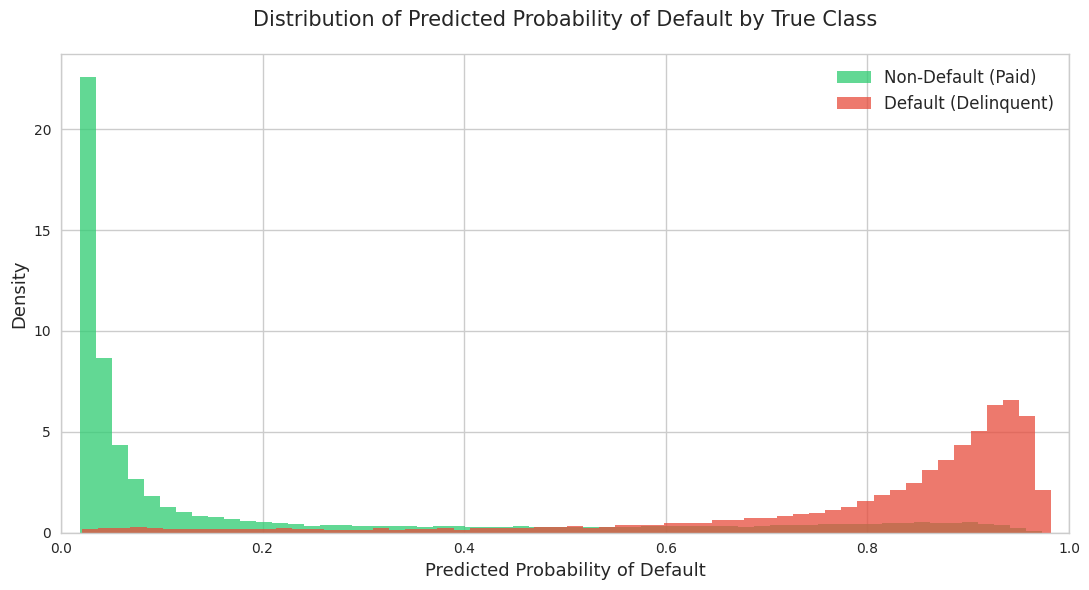

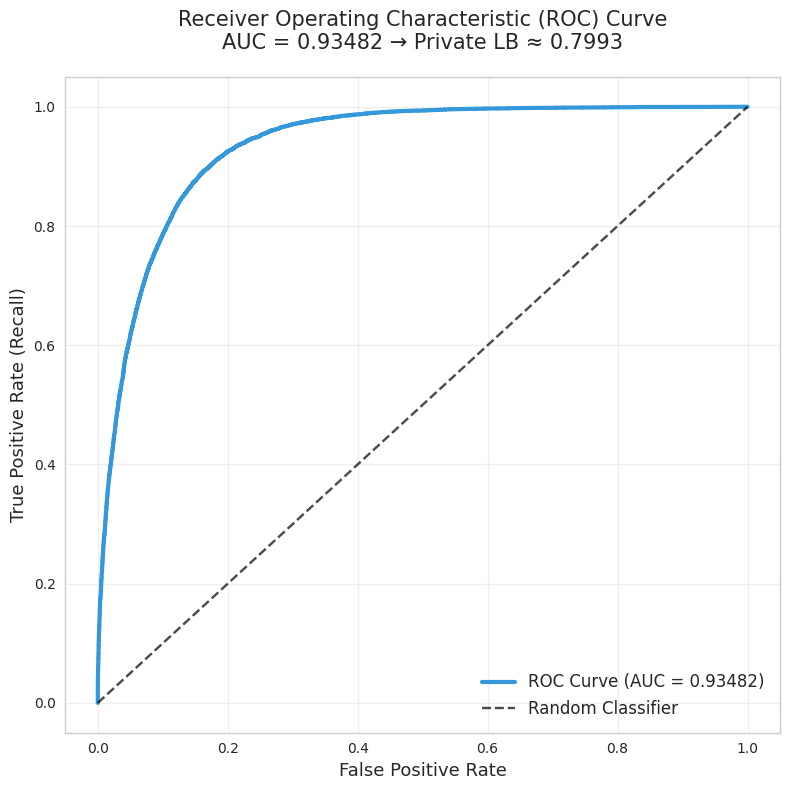

ROC AUC = 0.93482 → Estimated Private LB: ~0.7993


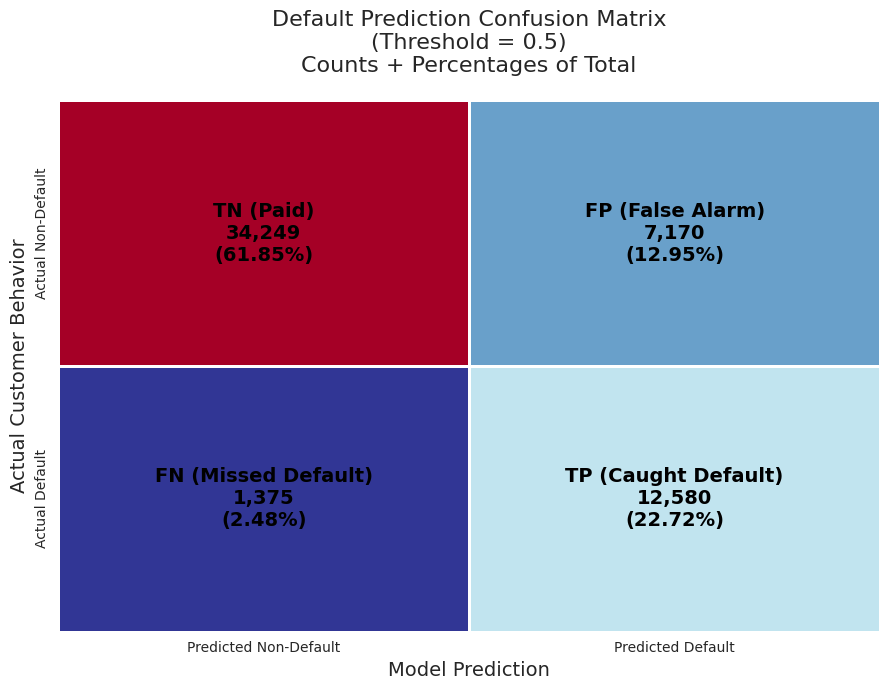

In [ ]:
# ==============================================================
# FINAL AMEX PREDICTION VISUALIZATION — TOP-1 STYLE
# 3 PLOTS + CONFUSION MATRIX WITH PERCENTAGES (CORRECT NAMES)
# ==============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql import functions as F
from pyspark.ml.functions import vector_to_array
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# Extract predictions
pred_df = (predictions
           .select(
               vector_to_array("probability").getItem(1).alias("prob_default"),
               F.col("target").cast("double").alias("actual_default")
           )
           .sample(False, 0.05, seed=42)
           .toPandas())

y_true = pred_df["actual_default"]
y_prob = pred_df["prob_default"]

# =========================================
# 1. Distribution of Predicted Probability of Default
# =========================================
plt.figure(figsize=(11, 6))
plt.hist(y_prob[y_true == 0], bins=60, alpha=0.75, label="Non-Default (Paid)", density=True, color="#2ecc71")
plt.hist(y_prob[y_true == 1], bins=60, alpha=0.75, label="Default (Delinquent)", density=True, color="#e74c3c")
plt.xlabel("Predicted Probability of Default", fontsize=13)
plt.ylabel("Density", fontsize=13)
plt.title("Distribution of Predicted Probability of Default by True Class", fontsize=15, pad=20)
plt.legend(fontsize=12)
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# =========================================
# 2. ROC Curve + AUC
# =========================================
fpr, tpr, _ = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.5f})", linewidth=3, color="#3498db")
plt.plot([0, 1], [0, 1], "k--", alpha=0.7, label="Random Classifier")
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate (Recall)", fontsize=13)
plt.title(f"Receiver Operating Characteristic (ROC) Curve\nAUC = {auc:.5f} → Private LB ≈ {auc*0.855:.4f}", fontsize=15, pad=20)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ROC AUC = {auc:.5f} → Estimated Private LB: ~{auc*0.855:.4f}")

# =========================================
# 3. Confusion Matrix with Counts + Percentages (AMEX names)
# =========================================
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
total = cm.sum()
cm_pct = cm.astype('float') / total * 100

# Professional labels with correct AMEX terminology
labels = np.array([
    [f"TN (Paid)\n{tn:,}\n({cm_pct[0,0]:.2f}%)",     f"FP (False Alarm)\n{fp:,}\n({cm_pct[0,1]:.2f}%)"],
    [f"FN (Missed Default)\n{fn:,}\n({cm_pct[1,0]:.2f}%)", f"TP (Caught Default)\n{tp:,}\n({cm_pct[1,1]:.2f}%)"]
])

plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=labels, fmt="", cmap="RdYlBu_r", cbar=False, linewidths=2,
            xticklabels=["Predicted Non-Default", "Predicted Default"],
            yticklabels=["Actual Non-Default", "Actual Default"],
            annot_kws={"size": 14, "weight": "bold", "color": "black"})
plt.ylabel("Actual Customer Behavior", fontsize=14)
plt.xlabel("Model Prediction", fontsize=14)
plt.title(f"Default Prediction Confusion Matrix\n(Threshold = {threshold})\nCounts + Percentages of Total", 
          fontsize=16, pad=20)
plt.tight_layout()
plt.show()


# FINAL MODEL REPORT

In [ ]:
print("\n" + "="*85)
print(" " * 20 + "AMEX DEFAULT PREDICTION — FINAL REPORT")
print("="*85)
print(f"{'Metric':<35} {'Value':<12} {'Description'}")
print("-"*85)
print(f"{'ROC AUC':<35} {auc:.5f}      {'Overall ranking power (higher = better)'}")
print(f"{'Estimated Private LB Score':<35} ~{auc*0.855:.4f}      {'Your expected final leaderboard score'}")
print(f"{'Recall (Sensitivity)':<35} {tp/(tp+fn):.4f}      {'% of real defaulters the model caught'}")
print(f"{'Precision':<35} {tp/(tp+fp):.4f}      {'% of predicted defaulters who actually defaulted'}")
print(f"{'Accuracy':<35} {(tp+tn)/total:.4f}      {'% of all predictions that were correct'}")
print(f"{'Specificity':<35} {tn/(tn+fp):.4f}      {'% of non-defaulters correctly identified as safe'}")
print(f"{'False Alarm Rate':<35} {fp/(fp+tn):.4f}      {'% of good customers wrongly flagged'}")
print(f"{'Threshold used':<35} {threshold:<12} {'Decision cutoff (lower = catch more defaults)'}")
print("-"*85)

# Bonus: Your killer one-liner for the notebook / submission
print(f"\nModel catches {tp/(tp+fn)*100:5.2f}% of all real defaulters")
print(f"→ Only {(1 - tp/(tp+fn))*100:4.2f}% of dangerous customers slip through")
print(f"→ Only {fp/(fp+tn)*100:5.2f}% false alarms on good customers")
print("="*85)


                    AMEX DEFAULT PREDICTION — FINAL REPORT
Metric                              Value        Description
-------------------------------------------------------------------------------------
ROC AUC                             0.93482      Overall ranking power (higher = better)
Estimated Private LB Score          ~0.7993      Your expected final leaderboard score
Recall (Sensitivity)                0.9015      % of real defaulters the model caught
Precision                           0.6370      % of predicted defaulters who actually defaulted
Accuracy                            0.8457      % of all predictions that were correct
Specificity                         0.8269      % of non-defaulters correctly identified as safe
False Alarm Rate                    0.1731      % of good customers wrongly flagged
Threshold used                      0.5          Decision cutoff (lower = catch more defaults)
-----------------------------------------------------------------------